     |████████████████████████████████| 11.8 MB 6.5 MB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1672718 sha256=f1d076098f08ba61883f07095ce3910694de99d7ba5912fbf248afd871a7847d
  Stored in directory: /home/ec2-user/.cache/pip/wheels/de/9a/41/6a57bf37eb7b50de7f8c7ca9d7053bebe0ea7c7c9bae9fa293
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [163]:
import sys
import re
import csv
import unicodedata
import sys
import time
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from surprise import Dataset
from surprise.reader import Reader
from surprise import accuracy
from surprise import get_dataset_dir
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from scipy import spatial
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD

import math
from sklearn.linear_model import LogisticRegression
import os 
os.getcwd()

'/home/ec2-user/SageMaker'

In [164]:
reviews_df=pd.read_csv('/home/ec2-user/SageMaker/beer_reviews.csv')

In [165]:
reviews_df

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


In [71]:
reviews_df.nunique() 

brewery_id               5840
brewery_name             5742
review_time           1577960
review_overall             10
review_aroma                9
review_appearance          10
review_profilename      33387
beer_style                104
review_palate               9
review_taste                9
beer_name               56857
beer_abv                  530
beer_beerid             66055
dtype: int64

This data set includes reviews on 66,055 unique beers from over 33,000 unique users. 

In [72]:
reviews_df.isna().mean().round(4) * 100

brewery_id            0.00
brewery_name          0.00
review_time           0.00
review_overall        0.00
review_aroma          0.00
review_appearance     0.00
review_profilename    0.02
beer_style            0.00
review_palate         0.00
review_taste          0.00
beer_name             0.00
beer_abv              4.27
beer_beerid           0.00
dtype: float64

I am going to drop the null rows because the dataset is large enought that such a small percentage shouldnt adversly affect any findings. 

In [166]:
review_df = reviews_df.dropna()

In [168]:
review_df.shape

(1518478, 13)

In [169]:
review_df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [170]:
review_df.reset_index()

,index,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518473,1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1518474,1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1518475,1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1518476,1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


In [171]:
reviews_df.corr()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
brewery_id,1.000000,0.220954,-0.009331,0.019069,0.001993,-0.000499,-0.002672,0.063731,0.424097
review_time,0.220954,1.000000,0.028724,0.067453,0.058233,0.057247,0.044498,0.144885,0.461535
review_overall,-0.009331,0.028724,1.000000,0.616013,0.501732,0.701914,0.789816,0.138512,0.003794
review_aroma,0.019069,0.067453,0.616013,1.000000,0.561029,0.616947,0.716776,0.332570,0.077669
review_appearance,0.001993,0.058233,0.501732,0.561029,1.000000,0.566634,0.546980,0.263941,0.054794
review_palate,-0.000499,0.057247,0.701914,0.616947,0.566634,1.000000,0.734135,0.286711,0.044510
review_taste,-0.002672,0.044498,0.789816,0.716776,0.546980,0.734135,1.000000,0.290827,0.030402
beer_abv,0.063731,0.144885,0.138512,0.332570,0.263941,0.286711,0.290827,1.000000,0.201818
beer_beerid,0.424097,0.461535,0.003794,0.077669,0.054794,0.044510,0.030402,0.201818,1.000000


Checking correlation can help determin if colinierity will be an issue when modeling. 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  app.launch_new_instance()


array([[<AxesSubplot:title={'center':'brewery_id'}>,
        <AxesSubplot:title={'center':'review_time'}>,
        <AxesSubplot:title={'center':'review_overall'}>],
       [<AxesSubplot:title={'center':'review_aroma'}>,
        <AxesSubplot:title={'center':'review_appearance'}>,
        <AxesSubplot:title={'center':'review_palate'}>],
       [<AxesSubplot:title={'center':'review_taste'}>,
        <AxesSubplot:title={'center':'beer_abv'}>,
        <AxesSubplot:title={'center':'beer_beerid'}>]], dtype=object)

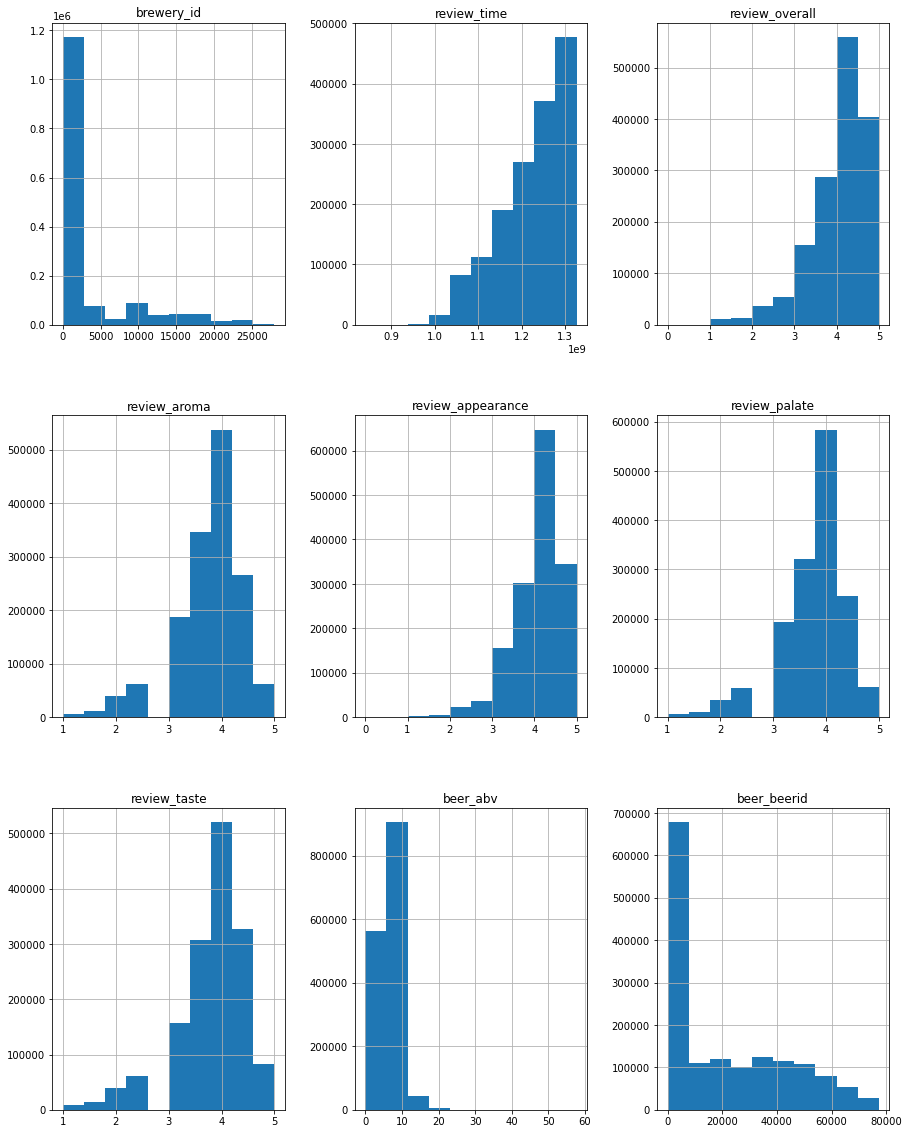

In [172]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
review_df.hist(ax = ax)

The review data all appear to have a simialr distribution. Most beers recieve a rating of 4 or higher. Using the describe method can alse verify what these pots are showing us in terms of the distribition as well as possible outliers. Desciions trees can be suseptable to outliers so getting a sense of what is there now can help fine tune the model late. 

In [173]:
review_df.describe()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06
mean,3.074306e+03,1.225332e+09,3.823938e+00,3.746218e+00,3.850383e+00,3.753735e+00,3.804082e+00,7.042488e+00,2.140575e+04
std,5.544339e+03,7.583455e+07,7.172663e-01,6.953440e-01,6.143106e-01,6.793350e-01,7.286079e-01,2.322568e+00,2.178033e+04
min,1.000000e+00,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,5.000000e+00
25%,1.410000e+02,1.175562e+09,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.654000e+03
50%,4.170000e+02,1.240356e+09,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.283000e+04
75%,2.298000e+03,1.289086e+09,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.923600e+04
max,2.800300e+04,1.326285e+09,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731600e+04


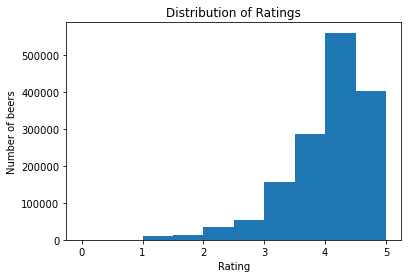

In [174]:
plt.figure()
plt.hist(review_df['review_overall'])
plt.xlabel('Rating')
plt.ylabel('Number of beers')
plt.title('Distribution of Ratings')
plt.show()

This distribution for the ratings indicates that drinking beer is a favorbale thing, over 50% of the reviews are a 4 or higher. 

Text(0.5, 1.0, 'Distribution of ABV %')

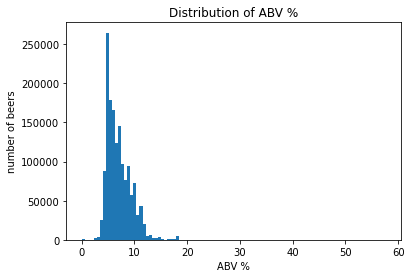

In [175]:
plt.figure()
plt.hist(review_df['beer_abv'], bins = 100)
plt.ylabel('number of beers')
plt.xlabel('ABV %')
plt.title('Distribution of ABV %')

This distribution of the alcohol by volume looks like most beers have an abv of 5% or greater. 

In [176]:
import seaborn as sns

<AxesSubplot:>

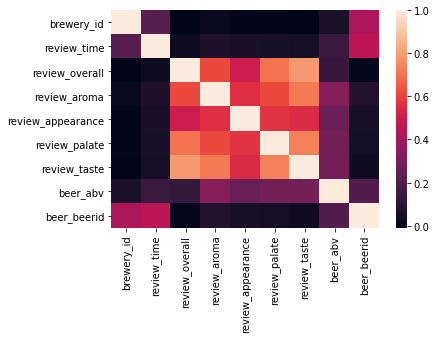

In [177]:
sns.heatmap(reviews_df.corr())

This heatmap is much easier to read and does a good job of showing some correlation between the overall rating and the other variables like taste, palate, and aroma. It also shows a low corelation bewteen overall review and alcohol percentage. I am adding a catagorical column with three levels based on alcohol percentage. One being low representing beers with less than 5%, 2 being medium represent beer betwwen 5 and 6.8% and finally three representing higher content beers which are 6.9% and above.

In [178]:
alc_level = []

for row in review_df['beer_abv']:
    if row < 5 : alc_level.append(1)
    elif row < 6.9: alc_level.append(2)
    else: alc_level.append(3)

In [179]:
 review_df['alc_level'] = alc_level

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


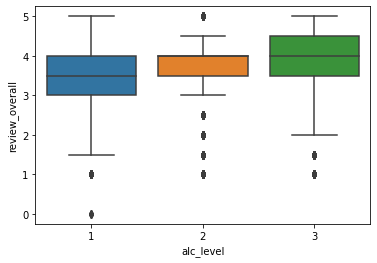

In [180]:
abv = sns.boxplot(x="alc_level", y="review_overall", data=review_df)

Across all types of beers, those with high alchohl content by volume receive more favorable ratings. 

I am going to drop the beers that have reciveied a 0 rating. 

In [181]:
indexNames = review_df[review_df['review_overall'] == 0.0 ].index

In [182]:
review_df.drop(indexNames , inplace=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [183]:
review_df.shape

(1518471, 14)

beer style is a varibale I want to keep to see if there are any interesting trends. To do this I am going to label encode, then one hot encode it. and create my data dictionay before dropping any columns.

In [184]:
review_df['beer_style'] = review_df['beer_style'].astype('category')
# Assigning numerical values and storing in another column
review_df['beer_style_cat'] = review_df['beer_style'].cat.codes
datadict_df = review_df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [185]:

from sklearn.preprocessing import OneHotEncoder

In [186]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(review_df[['beer_style_cat']]).toarray())
# merge with main df bridge_df on key values
review_df = review_df.join(enc_df)
review_df

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,...,94,95,96,97,98,99,100,101,102,103
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
base = review_df.drop(columns=['review_time', 'brewery_name', 'beer_style','beer_name', 'beer_style_cat', 'review_profilename', 'beer_beerid', 'alc_level', 'brewery_id'], axis=1)

In [188]:
base = base.dropna()

In [189]:
sample = base.sample(frac=.10, replace=True, random_state=42, axis=0)

In [190]:
from sklearn.model_selection import train_test_split

In [191]:
X=sample.drop(columns='review_overall')
y=sample.iloc[:, 0]

I am going to split the data into test and train splits. I want to test this both as a regression and classification problem. Regression will give us a chance of predicing a continus target, a score from 1-5 where as a classification approach will require us to create a dependent catagorical variable to predict. Predicitng a score on a scale of 1-5 will be more difficult but attempting both methods may give some insight into what features are most important.

In terms of trying to make a good beer that is popular, a 4 or higher in the overall review should fair well amungst users so for the classification we will consider anything with a rating of 4 or higher as good and anything less as bad. 

In [194]:
split = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)

In [195]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [196]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)

RandomForestRegressor()

In [197]:
decision_tree_scores = []
for sub_tree in random_forest.estimators_:
    decision_tree_scores.append(sub_tree.score(X_train, y_train))
    
print("Performance on fitted data:")
print(f"Average Decision Tree: {np.mean(decision_tree_scores)}")
print(f"Random Forest: {random_forest.score(X_train, y_train)}")

Performance on fitted data:
Average Decision Tree: 0.7673053401099756
Random Forest: 0.9129517509545935


In [198]:
decision_tree_scores = []
for sub_tree in random_forest.estimators_:
    decision_tree_scores.append(sub_tree.score(X_test, y_test))

print("Performance on Test data:")
print(f"Average Decision Tree: {np.mean(decision_tree_scores)}")
print(f"Random Forest: {random_forest.score(X_test, y_test)}")

Performance on Test data:
Average Decision Tree: 0.4382564656471836
Random Forest: 0.6333301563770402


In [119]:
from sklearn.inspection import permutation_importance
random_forest.feature_importances_

array([3.18545280e-02, 3.41894872e-02, 4.18274479e-02, 6.47103780e-01,
       8.65358520e-02, 1.01323918e-03, 2.95396657e-03, 3.84527002e-03,
       9.75932004e-04, 2.62031832e-03, 1.29081660e-03, 1.50427096e-03,
       2.93500814e-03, 2.64354195e-04, 5.50853508e-03, 8.84144318e-04,
       4.36023884e-03, 6.13248291e-03, 7.41068152e-04, 4.46576044e-03,
       1.03638079e-03, 2.68675187e-03, 3.77099092e-03, 2.37903110e-03,
       3.20488277e-03, 1.97061656e-03, 1.43210057e-03, 1.00503885e-03,
       1.73798705e-03, 2.05733989e-03, 3.47815993e-03, 2.68274784e-03,
       4.44239222e-04, 2.58714563e-04, 6.89123482e-04, 2.73538001e-04,
       1.37611210e-03, 2.79359019e-04, 4.33407645e-04, 3.50787341e-04,
       7.28599106e-04, 1.57264075e-03, 2.19001183e-03, 5.22373294e-04,
       2.25464949e-03, 1.05063733e-03, 5.32389924e-04, 1.57585773e-03,
       1.11444872e-03, 1.80822799e-03, 3.63282163e-04, 1.86353169e-03,
       2.32540629e-03, 1.23424691e-04, 1.39013746e-03, 3.57780838e-04,
      

In [210]:
important_features_dict = {}
for idx, val in enumerate(random_forest.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print(f'10 most important features: {important_features_list[:10]}')

5 most important features: [3, 4, 2, 1, 0, 17, 14, 19, 16, 94]


In [200]:
sample

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,0,1,2,3,...,94,95,96,97,98,99,100,101,102,103
125728,3.5,4.5,4.0,4.0,4.5,6.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
698301,3.5,3.0,4.5,3.5,3.5,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136339,3.0,3.5,4.0,4.0,3.5,5.6,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1479081,3.5,4.0,3.5,3.5,4.0,7.9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
268709,3.0,3.5,4.0,3.0,3.5,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192951,3.5,3.5,4.5,4.5,4.5,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1123796,4.0,4.5,4.0,4.5,4.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23717,5.0,4.0,4.5,5.0,4.5,8.3,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
884043,4.0,4.0,4.0,4.5,4.5,8.9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we are going to try the classification problem and will start by adding the categorical column to predict. 

In [202]:
sample['good_beer'] = np.where(sample['review_overall'] >= 4, 1, 0)
sample.head(3)

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,0,1,2,3,...,95,96,97,98,99,100,101,102,103,good_beer
125728,3.5,4.5,4.0,4.0,4.5,6.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
698301,3.5,3.0,4.5,3.5,3.5,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
136339,3.0,3.5,4.0,4.0,3.5,5.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [203]:
sample = sample.drop(columns='review_overall', axis=1)

In [204]:
sample.head(1)

,review_aroma,review_appearance,review_palate,review_taste,beer_abv,0,1,2,3,4,...,95,96,97,98,99,100,101,102,103,good_beer
125728,4.5,4.0,4.0,4.5,6.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [205]:
X=sample.iloc[:, :-1]
y=sample.iloc[:, -1]

In [206]:
split = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)

In [208]:
random_forest_class = RandomForestClassifier()
random_forest_class.fit(X_train, y_train)

RandomForestClassifier()

In [129]:
decision_tree_scores = []
for sub_tree in random_forest_class.estimators_:
    decision_tree_scores.append(sub_tree.score(X_train, y_train))
    
print("Performance on fitted data:")
print(f"Average Decision Tree: {np.mean(decision_tree_scores)}")
print(f"Random Forest: {random_forest_class.score(X_train, y_train)}")

Performance on fitted data:
Average Decision Tree: 0.8996525263654966
Random Forest: 0.9634523059971667


In [130]:
decision_tree_scores = []
for sub_tree in random_forest_class.estimators_:
    decision_tree_scores.append(sub_tree.score(X_test, y_test))

print("Performance on Test data:")
print(f"Average Decision Tree: {np.mean(decision_tree_scores)}")
print(f"Random Forest: {random_forest_class.score(X_test, y_test)}")

Performance on Test data:
Average Decision Tree: 0.7761711504912313
Random Forest: 0.8162932696722064


In [135]:
random_forest_class.feature_importances_

array([1.07320824e-01, 7.31578110e-02, 1.60406494e-01, 2.79860186e-01,
       2.04540086e-01, 1.09113382e-03, 2.85201896e-03, 3.34681183e-03,
       1.60221853e-03, 2.59461118e-03, 1.85209882e-03, 1.70736470e-03,
       2.88417765e-03, 2.80400070e-04, 5.08283529e-03, 1.28395303e-03,
       3.85863912e-03, 5.40788662e-03, 8.88558285e-04, 4.23285525e-03,
       1.43957841e-03, 2.89599370e-03, 3.69774546e-03, 2.86931642e-03,
       3.23682625e-03, 2.36364935e-03, 1.94273791e-03, 1.08731963e-03,
       1.96622019e-03, 2.39095233e-03, 2.87998852e-03, 2.70903347e-03,
       5.64628959e-04, 2.41286803e-04, 1.04533222e-03, 3.80240533e-04,
       1.69961968e-03, 3.67483684e-04, 6.52614664e-04, 4.31441398e-04,
       9.21931339e-04, 1.79731743e-03, 2.45611069e-03, 7.82088368e-04,
       2.43323586e-03, 1.04771231e-03, 6.99820005e-04, 2.10535147e-03,
       1.35486596e-03, 2.11372742e-03, 5.35777923e-04, 2.11228935e-03,
       2.58250652e-03, 1.95058290e-04, 1.79900387e-03, 5.50337836e-04,
      

In [209]:
important_features_dict = {}
for idx, val in enumerate(random_forest_class.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print(f'10 most important features: {important_features_list[:10]}')

5 most important features: [3, 4, 2, 0, 1, 17, 14, 94, 19, 16]


In [220]:
y_pred = random_forest.predict(X_test)

In [221]:
y_pred2 = random_forest_class.predict(X_test)

In [222]:
reg_pred_df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
class_pred_df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred2})


In [223]:
reg_pred_df

,Actual,Predicted
1507932,0,3.130000
317898,0,3.652500
1481561,1,4.451750
34686,1,3.363500
178494,1,4.002500
...,...,...
1275908,1,4.209833
324187,1,3.295000
424153,0,3.320000
471266,0,3.747667


In [224]:
class_pred_df

,Actual,Predicted
1507932,0,0
317898,0,1
1481561,1,1
34686,1,1
178494,1,1
...,...,...
1275908,1,1
324187,1,0
424153,0,0
471266,0,1


looking at the predicitons you can see the difference first hand between the regression and classification models results. 

In [211]:
datadict_df

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,alc_level,beer_style_cat
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986,2,65
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213,2,51
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215,2,59
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969,2,61
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061,2,85
1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061,2,85
1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061,2,85
1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061,2,85


In [217]:
datadict_df.loc[datadict_df['beer_style_cat'] == 94]

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,alc_level,beer_style_cat
1749,1454,Broad Ripple Brew Pub,1264534216,4.5,4.0,4.0,brundo4,Scotch Ale / Wee Heavy,3.5,4.0,Wee Alec Heavy,7.7,8284,3,94
1750,1454,Broad Ripple Brew Pub,1262208342,5.0,4.5,5.0,JamesS,Scotch Ale / Wee Heavy,5.0,4.5,Wee Alec Heavy,7.7,8284,3,94
1751,1454,Broad Ripple Brew Pub,1171332015,3.0,2.5,3.0,beveritt,Scotch Ale / Wee Heavy,3.0,3.5,Wee Alec Heavy,7.7,8284,3,94
1752,1454,Broad Ripple Brew Pub,1153231443,4.0,4.0,3.5,BlackAngus,Scotch Ale / Wee Heavy,4.0,4.5,Wee Alec Heavy,7.7,8284,3,94
1753,1454,Broad Ripple Brew Pub,1138130168,4.0,4.0,4.0,Bierguy5,Scotch Ale / Wee Heavy,3.5,4.0,Wee Alec Heavy,7.7,8284,3,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585462,3835,Drake's Brewing Co.,1134275912,3.5,3.5,3.5,lou91,Scotch Ale / Wee Heavy,3.5,4.0,Drake's Barrel Aged Jolly Rodger,11.0,27290,3,94
1586139,2845,Invercargill Brewery,1319937675,2.5,3.5,4.0,lacqueredmouse,Scotch Ale / Wee Heavy,2.0,2.5,Men'n Skurrts,7.0,72149,3,94
1586140,2845,Invercargill Brewery,1315384999,4.0,4.0,4.5,dgilks,Scotch Ale / Wee Heavy,3.5,4.0,Men'n Skurrts,7.0,72149,3,94
1586141,2845,Invercargill Brewery,1314406769,3.5,4.0,3.0,CrazyDavros,Scotch Ale / Wee Heavy,2.5,3.5,Men'n Skurrts,7.0,72149,3,94


Above is the data directory